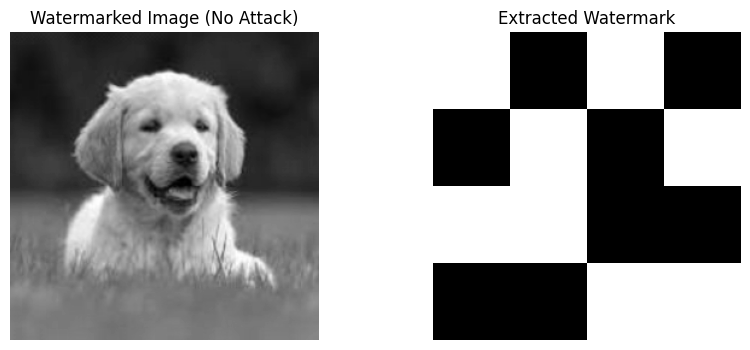

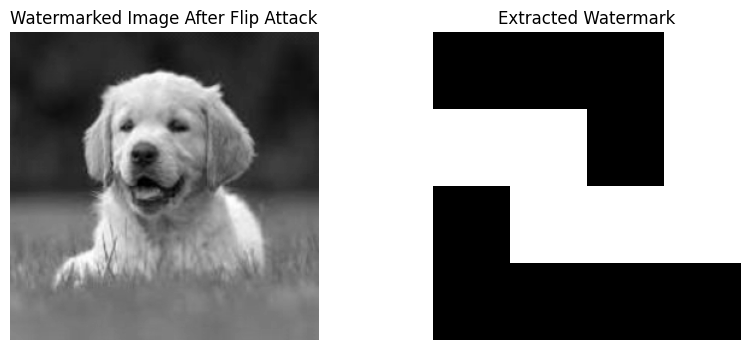

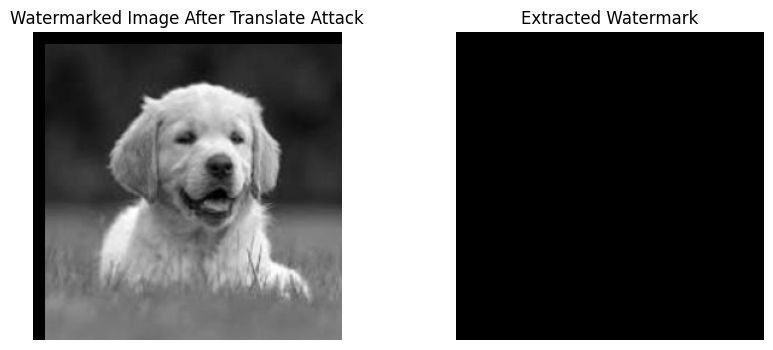

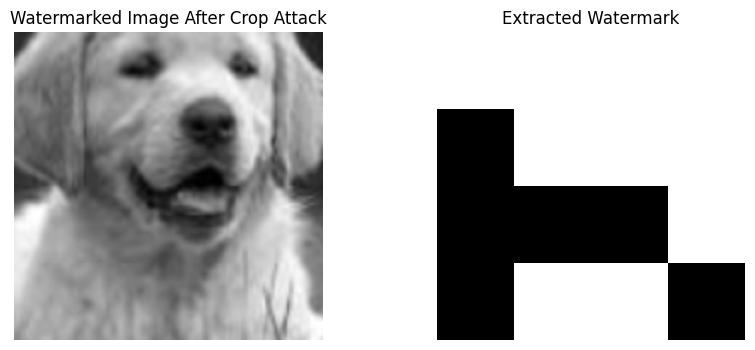

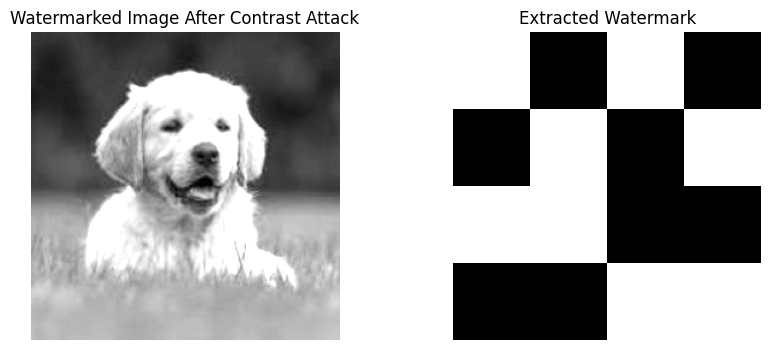

In [5]:
# 📦 安装依赖（Kaggle 已预装 opencv-python 和 matplotlib）
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 🎯 实验参数
block_size = 8  # DCT块大小
embed_pos = (4, 4)  # DCT中频位置嵌入水印
alpha = 10  # 嵌入强度

# 📌 水印位图（可以换成自定义logo/二维码）
watermark = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 1]
], dtype=np.uint8)

# 📥 加载图像（Kaggle 输入路径可以换成 /kaggle/input/...）
img = cv2.imread('/kaggle/input/dog22222/dog.jpg', cv2.IMREAD_GRAYSCALE)

if img is None:
    # 若找不到图像则使用随机图像代替
    img = np.ones((256, 256), dtype=np.uint8) * 128
else:
    img = cv2.resize(img, (256, 256))

# 将图像裁剪为 block_size 的整数倍大小
h, w = img.shape
img = img[:h // block_size * block_size, :w // block_size * block_size]

# 🧊 DCT 域水印嵌入
def embed_watermark(img, watermark, alpha):
    img = np.float32(img)
    wm_h, wm_w = watermark.shape
    idx = 0
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = img[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(block)
            if idx < wm_h * wm_w:
                bit = watermark[idx // wm_w, idx % wm_w]
                dct_block[embed_pos] += alpha if bit == 1 else -alpha
            block_idct = cv2.idct(dct_block)
            img[i:i + block_size, j:j + block_size] = block_idct
            idx += 1
    return np.uint8(np.clip(img, 0, 255))

# 🧊 DCT 域水印提取
def extract_watermark(img, shape, alpha):
    img = np.float32(img)
    wm = np.zeros(shape, dtype=np.uint8)
    wm_h, wm_w = shape
    idx = 0
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            if idx >= wm_h * wm_w: break
            block = img[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(block)
            wm[idx // wm_w, idx % wm_w] = 1 if dct_block[embed_pos] > 0 else 0
            idx += 1
    return wm

# 🔒 嵌入水印
watermarked = embed_watermark(img.copy(), watermark, alpha)

# 🧪 攻击函数
def attack_image(img, mode='flip'):
    if mode == 'flip':
        return cv2.flip(img, 1)  # 水平翻转
    elif mode == 'translate':
        M = np.float32([[1, 0, 10], [0, 1, 10]])
        return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    elif mode == 'crop':
        h, w = img.shape
        cropped = img[h//4:3*h//4, w//4:3*w//4]
        return cv2.resize(cropped, (w, h))  # 恢复原始大小
    elif mode == 'contrast':
        return cv2.convertScaleAbs(img, alpha=1.5, beta=0)
    return img

# 🔍 显示图像与水印
def show_results(img_with_attack, title):
    extracted = extract_watermark(img_with_attack, watermark.shape, alpha)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img_with_attack, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Extracted Watermark")
    plt.imshow(extracted, cmap='gray')
    plt.axis('off')
    plt.show()

# ✅ 原始水印图像展示
show_results(watermarked, "Watermarked Image (No Attack)")

# 🧪 依次进行攻击测试并提取水印
for mode in ['flip', 'translate', 'crop', 'contrast']:
    attacked = attack_image(deepcopy(watermarked), mode)
    show_results(attacked, f"Watermarked Image After {mode.capitalize()} Attack")


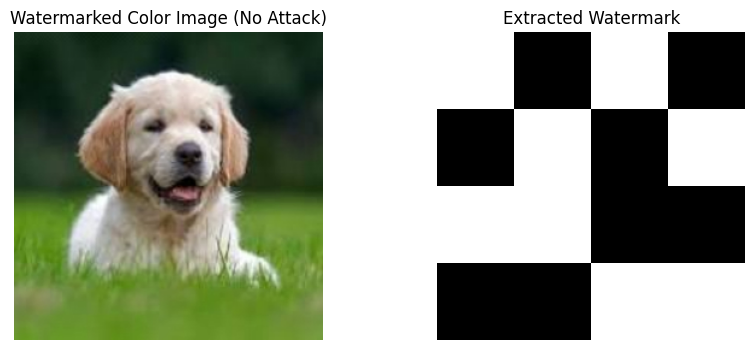

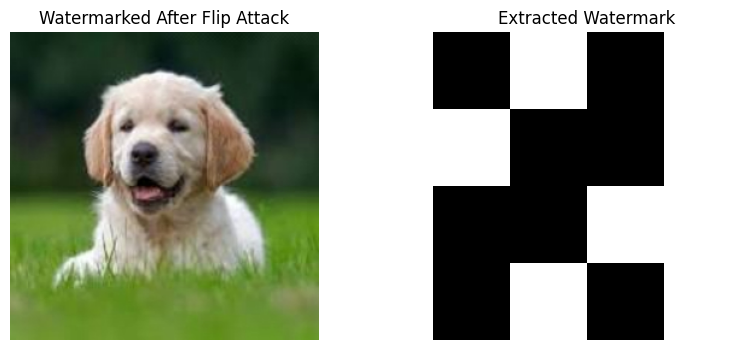

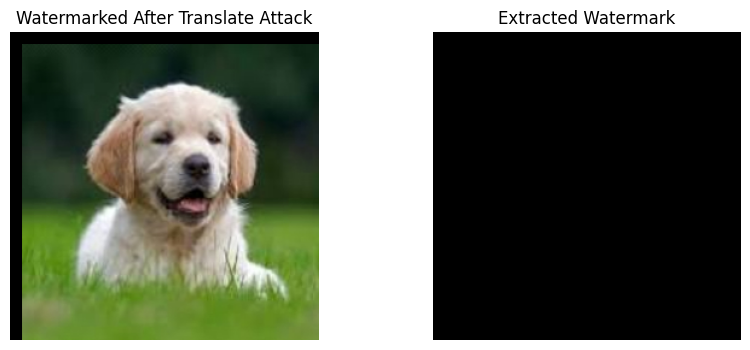

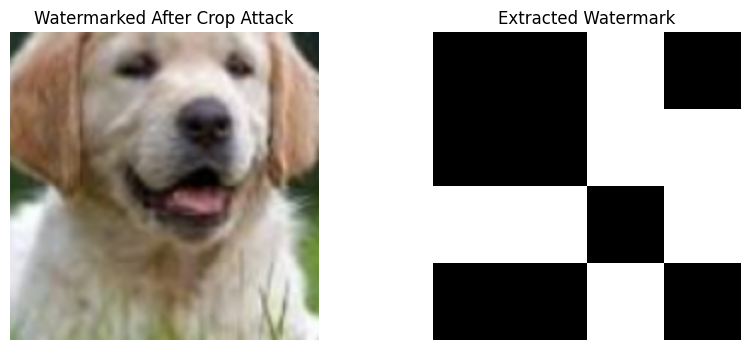

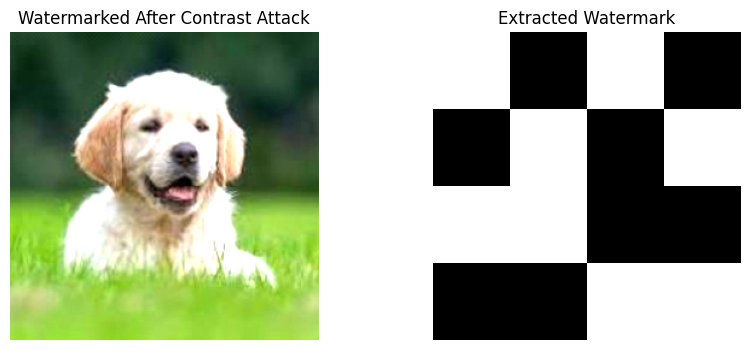

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# 🎯 参数设置
block_size = 8
embed_pos = (4, 4)
alpha = 10

# 📌 二值水印矩阵（你可替换为二维码等）
watermark = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 1, 0, 0],
    [0, 0, 1, 1]
], dtype=np.uint8)

# 📥 加载彩色图像
img_color = cv2.imread('/kaggle/input/dog22222/dog.jpg', cv2.IMREAD_COLOR)
if img_color is None:
    raise FileNotFoundError("❌ 图像加载失败，请检查路径。")

img_color = cv2.resize(img_color, (256, 256))

# 📺 转换为 YCrCb 模式，提取 Y 通道
img_ycrcb = cv2.cvtColor(img_color, cv2.COLOR_BGR2YCrCb)
Y_channel = img_ycrcb[:, :, 0]

# ✂️ 保证 Y 通道尺寸为 block_size 的整数倍
h, w = Y_channel.shape
Y_channel = Y_channel[:h // block_size * block_size, :w // block_size * block_size]

# 🧊 DCT 域嵌入
def embed_watermark(Y, watermark, alpha):
    Y = np.float32(Y)
    wm_h, wm_w = watermark.shape
    idx = 0
    for i in range(0, Y.shape[0], block_size):
        for j in range(0, Y.shape[1], block_size):
            block = Y[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(block)
            if idx < wm_h * wm_w:
                bit = watermark[idx // wm_w, idx % wm_w]
                dct_block[embed_pos] += alpha if bit == 1 else -alpha
            block_idct = cv2.idct(dct_block)
            Y[i:i + block_size, j:j + block_size] = block_idct
            idx += 1
    return np.uint8(np.clip(Y, 0, 255))

# 🧊 提取水印
def extract_watermark(Y, shape, alpha):
    Y = np.float32(Y)
    wm = np.zeros(shape, dtype=np.uint8)
    wm_h, wm_w = shape
    idx = 0
    for i in range(0, Y.shape[0], block_size):
        for j in range(0, Y.shape[1], block_size):
            if idx >= wm_h * wm_w: break
            block = Y[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(block)
            wm[idx // wm_w, idx % wm_w] = 1 if dct_block[embed_pos] > 0 else 0
            idx += 1
    return wm

# 💧 嵌入水印后合成回彩色图像
Y_embed = embed_watermark(Y_channel.copy(), watermark, alpha)
img_ycrcb[:, :, 0] = Y_embed
watermarked_color = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)

# 🧪 攻击（彩色图）
def attack_image(img, mode='flip'):
    if mode == 'flip':
        return cv2.flip(img, 1)
    elif mode == 'translate':
        M = np.float32([[1, 0, 10], [0, 1, 10]])
        return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    elif mode == 'crop':
        h, w = img.shape[:2]
        cropped = img[h//4:3*h//4, w//4:3*w//4]
        return cv2.resize(cropped, (w, h))
    elif mode == 'contrast':
        return cv2.convertScaleAbs(img, alpha=1.5, beta=0)
    return img

# 📊 显示结果
def show_results(attacked_img, title):
    ycrcb = cv2.cvtColor(attacked_img, cv2.COLOR_BGR2YCrCb)
    Y = ycrcb[:, :, 0]
    wm_extracted = extract_watermark(Y, watermark.shape, alpha)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(cv2.cvtColor(attacked_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Extracted Watermark")
    plt.imshow(wm_extracted, cmap='gray')
    plt.axis('off')
    plt.show()

# ✅ 原图结果展示
show_results(watermarked_color, "Watermarked Color Image (No Attack)")

# 🧪 攻击测试
for mode in ['flip', 'translate', 'crop', 'contrast']:
    attacked_color = attack_image(deepcopy(watermarked_color), mode)
    show_results(attacked_color, f"Watermarked After {mode.capitalize()} Attack")
